In [6]:
import mindspore

# mindspore.dataset
import mindspore.dataset as ds # 数据集的载入
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子

# mindspore.common
from mindspore.common import dtype as mstype # 数据形态转换
from mindspore.common.initializer import Normal # 参数初始化

# mindspore.nn
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.nn.metrics import Accuracy, Loss # 测试模型用

# mindspore.train.callback
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback # 回调函数


from mindspore import Model # 承载网络结构
from mindspore import save_checkpoint, load_checkpoint # 保存与读取最佳参数
from mindspore import context # 设置mindspore运行的环境


import numpy as np # numpy
import matplotlib.pyplot as plt # 可视化用
import copy # 保存网络参数用

# 数据路径处理
import os, stat

In [18]:
device_target = context.get_context('device_target') 
# 获取运行装置（CPU，GPU，Ascend）
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False 
# 是否将数据通过pipeline下发到装置上
context.set_context(mode = context.GRAPH_MODE, device_target = device_target) 
# 设置运行环境，静态图context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕

print(f'device_target: {device_target}')
print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: Ascend
dataset_sink_mode: True


In [7]:
# 数据路径
train_path = os.path.join('data','10-batches-bin') # 训练集路径
test_path = os.path.join('data','10-verify-bin') #请填写测试集路径
print(f'训练集路径：{train_path}')
print(f'测试集路径：{test_path}') 

训练集路径：data/10-batches-bin
测试集路径：data/10-verify-bin


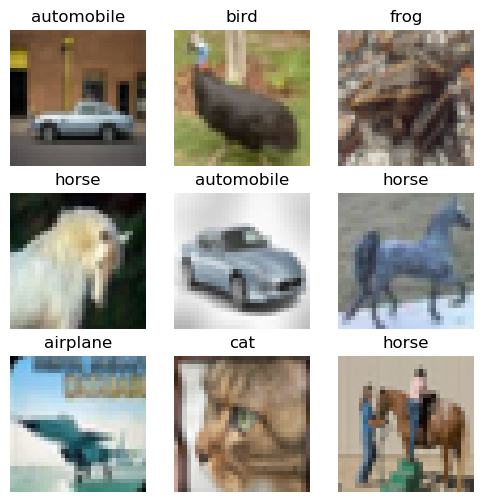

In [8]:
# 创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}# 请补充图片的类别

# 载入展示用数据
demo_data = ds.Cifar10Dataset(test_path)

# 设置图像大小
plt.figure(figsize=(6, 6))

# 打印9张子图
i = 1
for dic in demo_data.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy()) # asnumpy：将 MindSpore tensor 转换成 numpy
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    i +=1
    if i > 9 :
        break

plt.show() 

In [9]:
ds_train = ds.Cifar10Dataset(train_path)
#计算数据集平均数和标准差，数据标准化时使用
tmp = np.asarray( [x['image'] for x in ds_train.create_dict_iterator(output_numpy=True)] )
RGB_mean = tuple(np.mean(tmp, axis=(0, 1, 2)))
RGB_std = tuple(np.std(tmp, axis=(0, 1, 2))) #请补充np函数以计算标准差

print(RGB_mean)
print(RGB_std)

(125.306918046875, 122.950394140625, 113.86538318359375)
(62.99321927773442, 62.08870764037181, 66.70489964063688)


In [10]:
def create_dataset(data_path, batch_size = 32, repeat_num=1, usage = 'train'):
    """ 
    数据处理
    
    Args:
        data_path (str): 数据路径
        batch_size (int): 批量大小
        usage (str): 训练或测试
        
    Returns:
        Dataset对象
    """
    
    # 载入数据集
    data = ds.Cifar10Dataset(data_path)
    
    # 打乱数据集
    data = data.shuffle(buffer_size=10000)
    
    # 定义算子
    if usage=='train':
        trans = [
            CV.Normalize(RGB_mean, RGB_std), # 数据标准化

            # 数据增强
            CV.RandomCrop([32, 32], [4, 4, 4, 4]), # 随机裁剪
            CV.RandomHorizontalFlip(), # 随机翻转

            CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
        ]
    else:
        trans = [
            CV.Normalize(RGB_mean, RGB_std), # 数据标准化
            CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
        ]
    
    typecast_op = C.TypeCast(mstype.int32) # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(input_columns='label', operations=typecast_op)
    data = data.map(input_columns='image', operations=trans)
    
    # 批处理
    data = data.batch(batch_size, drop_remainder=True)
    
    # 重复
    data = data.repeat(repeat_num)
    
    return data

In [11]:
class LeNet5(nn.Cell):
    """
    LeNet5网络

    Args:
        num_class (int): 输出分类数
        num_channel (int): 输入通道数
    Returns:
        Tensor, 输出张量

    Examples:
        >>> LeNet5(10, 3)
    """
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        # 全连接层
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化成
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 网络展开
        self.flatten = nn.Flatten()
        # 建构网络
# 请根据Lenet网络结构，构建如下模型，请留意，卷积层后需要加激活函数
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [12]:
train_data = create_dataset(train_path, batch_size = 32, usage = 'train') # 训练数据集
test_data = create_dataset(test_path, batch_size = 50, usage= 'test') # 测试数据集，请补充测试数据集路径 

In [13]:
# 网络
network1 = LeNet5(10)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
net_opt = nn.Momentum(params=network1.trainable_params(), learning_rate=0.01, momentum=0.9)

# 模型，请补充模型的超参数
model = Model(network = network1, loss_fn = net_loss, optimizer = net_opt, metrics={'accuracy': Accuracy(), 'loss':Loss()}) 

In [14]:
# 记录模型每个epoch的loss
class TrainHistroy(Callback):
    """
    记录模型训练时每个epoch的loss的回调函数

    Args:
        history (list): 传入list以保存模型每个epoch的loss
    """
    
    def __init__(self, history):
        super(TrainHistroy, self).__init__()
        self.history = history
        
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)
        

# 测试并记录模型在测试集的loss和accuracy，每个epoch结束时进行模型测试并记录结果，跟踪并保存准确率最高的模型网络参数
class EvalHistory(Callback):
    """
    记录模型训练时每个epoch在测试集的loss和accuracy的回调函数，并保存准确率最高的模型网络参数

    Args:
        model (Cell): 模型，评估loss和accuracy用
        loss_history (list): 传入list以保存模型每个epoch在测试集的loss
        acc_history (list): 传入list以保存模型每个epoch在测试集的accuracy
        eval_data (Dataset): 测试集，评估模型loss和accuracy用
    """
    
    #保存accuracy最高的网络参数
    best_param = None
    
    def __init__(self, model, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()
        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
        self.model = model
    
    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)
        
        if len(self.acc_history)==0 or res['accuracy']>=max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)
            
        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])
        
        print('acc_eval: ',res['accuracy'])
    
    # 训练结束后执行
    def end(self, run_context):
        # 保存最优网络参数
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')
        
        if os.path.exists(best_param_path):
            # best_param.ckpt已存在时MindSpore会覆盖旧的文件，这里修改文件读写权限防止报错
            os.chmod(best_param_path, stat.S_IWRITE)
            
        save_checkpoint(self.best_param, best_param_path)
        

In [21]:
ckpt_path = os.path.join('.','results') # 网络参数保存路径
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 网络参数自动保存，这里设定每2000个step保存一次，最多保存10次
config_ck = CheckpointConfig(save_checkpoint_steps=2000,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet', directory=ckpt_path, config=config_ck)

# 监控每次迭代的时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

# 监控loss值
loss_cb = LossMonitor(per_print_times=500)

# 记录每次迭代的模型损失值
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

In [23]:
epoch = 10 # 迭代次数
dataset_sink_mode = True
# 开始训练
model.train(epoch, train_data, callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, loss_cb], dataset_sink_mode=dataset_sink_mode)

acc_eval:  0.2638
epoch time: 50458.585 ms, per step time: 32.304 ms
acc_eval:  0.4509
epoch time: 3651.299 ms, per step time: 2.338 ms
acc_eval:  0.482
epoch time: 3687.913 ms, per step time: 2.361 ms
acc_eval:  0.5384
epoch time: 3932.321 ms, per step time: 2.517 ms
acc_eval:  0.5279
epoch time: 3570.650 ms, per step time: 2.286 ms
acc_eval:  0.5743
epoch time: 3762.572 ms, per step time: 2.409 ms
acc_eval:  0.5641
epoch time: 3767.933 ms, per step time: 2.412 ms
acc_eval:  0.5729
epoch time: 3650.961 ms, per step time: 2.337 ms
acc_eval:  0.5707
epoch time: 3660.323 ms, per step time: 2.343 ms
acc_eval:  0.5726
epoch time: 3079.756 ms, per step time: 1.972 ms


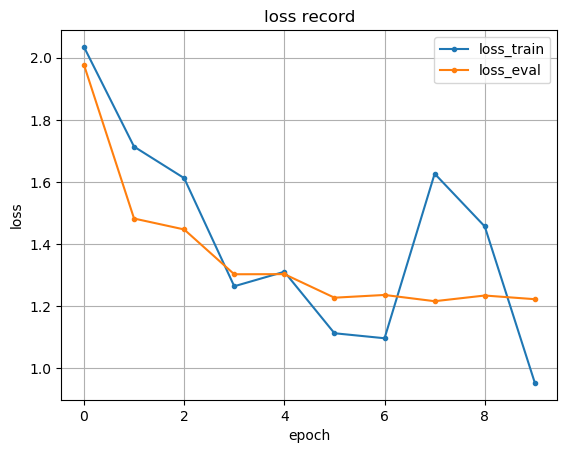

In [25]:
# 定义loss记录绘制函数
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()

plot_loss(hist) 

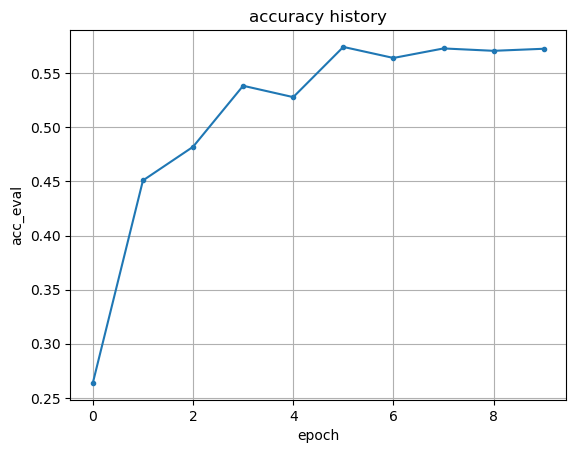

In [26]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()

plot_accuracy(hist) 

In [27]:
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network1)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

{'accuracy': 0.5743, 'loss': 1.226685506105423}


In [29]:
class LeNet5_2(nn.Cell):
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5_2, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 32, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv2 = nn.Conv2d(32, 64, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv3 = nn.Conv2d(64, 128, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.fc1 = nn.Dense(128*2*2, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.num_class = num_class
    
    # 构建网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [30]:
# 如果已将数据通过pipeline下发到装置上，使用新的model需要重新载入数据
if dataset_sink_mode:
    # 训练数据集预处理
    train_data = create_dataset(train_path, batch_size = 32, usage = 'train')
    # 测试数据集预处理
    test_data = create_dataset(test_path, batch_size = 50, usage = 'test')

In [31]:
# 网络
network2 = LeNet5_2(10)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
net_opt = nn.Adam(params=network2.trainable_params())

# 模型，请补充model的超参数
model = Model(network = network2, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss':Loss()})

In [32]:
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 网络参数自动保存，这里设定每2000个step保存一次，最多保存10次
config_ck = CheckpointConfig(save_checkpoint_steps=2000, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet_2', directory=ckpt_path, config=config_ck)

# 记录每次迭代的模型准确率
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

In [33]:
epoch = 10 # 迭代次数
# 开始训练
model.train(epoch, train_data, 
            callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, LossMonitor(per_print_times=500)], 
            dataset_sink_mode=dataset_sink_mode)

acc_eval:  0.4595
epoch time: 29208.034 ms, per step time: 18.699 ms
acc_eval:  0.577
epoch time: 3892.089 ms, per step time: 2.492 ms
acc_eval:  0.6314
epoch time: 4271.392 ms, per step time: 2.735 ms
acc_eval:  0.6552
epoch time: 4044.672 ms, per step time: 2.589 ms
acc_eval:  0.684
epoch time: 3794.017 ms, per step time: 2.429 ms
acc_eval:  0.694
epoch time: 3936.868 ms, per step time: 2.520 ms
acc_eval:  0.7051
epoch time: 3892.418 ms, per step time: 2.492 ms
acc_eval:  0.7296
epoch time: 4026.026 ms, per step time: 2.577 ms
acc_eval:  0.7306
epoch time: 3806.334 ms, per step time: 2.437 ms
acc_eval:  0.7387
epoch time: 3270.911 ms, per step time: 2.094 ms


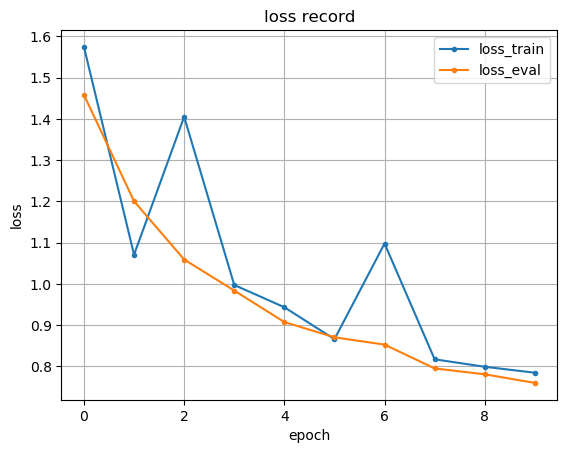

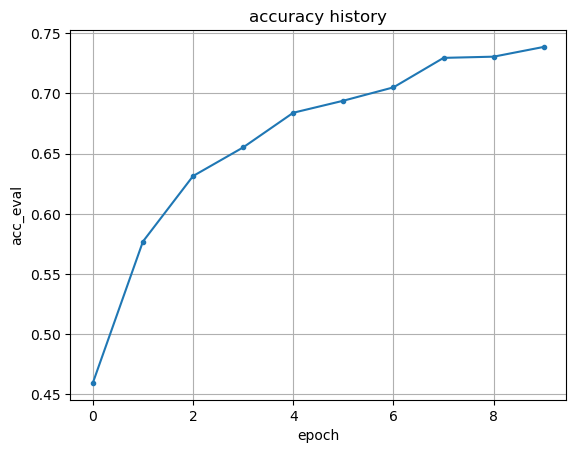

{'accuracy': 0.7387, 'loss': 0.7596679058670998}


In [34]:
plot_loss(hist)
plot_accuracy(hist)
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
best_param = mindspore.load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network2)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

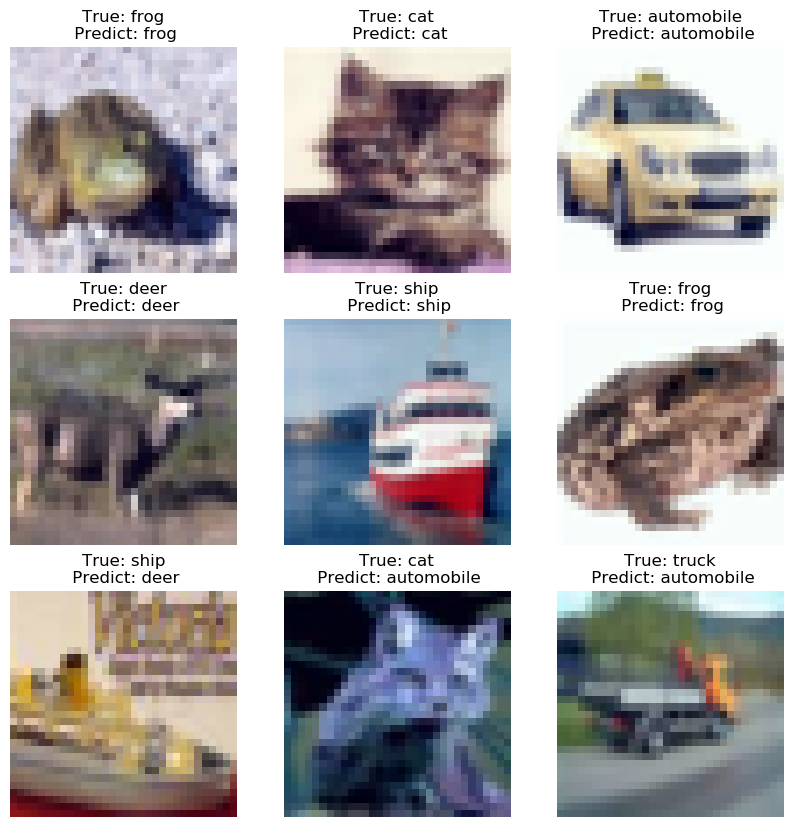

In [35]:
#创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

data_path=os.path.join('data', '10-verify-bin')

demo_data = create_dataset(test_path, batch_size=1, usage='test')

# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in demo_data.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
    
    # 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0) # 删除batch维度，方便可视化
    input_image = input_image.transpose(1,2,0) # CHW转HWC，方便可视化
    input_image = normalize(input_image) # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break

plt.show()